# RR Lyrae Period-Luminosity

Eric Bellm
January 2022

In this exercise we'll use real data from a variety of surveys to learn more about the relationship between an RR Lyrae variable's period and its luminosity.

In [1]:
# !pip install fastparquet

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle

## 1. Finding the Period of an RR Lyrae star

We begin by loading the ZTF lightcurve of a previously-identified RR Lyrae star.  We've pre-written this function for you.

In [3]:
def load_ztf_lc(filename):
    """Load a ZTF parquet lightcurve saved by `ztf_query`.
    
    See `ZTF_RRLyrae_data.ipynb` for data retrieval.
    
    Parameters
    ----------
    filename : string
        path to a parquet file saved by `ztf_query`
        
    Returns
    -------
    tbl : `astropy.timeseries.TimeSeries`
        lightcurve 
    mean_ra : `float`
        mean right ascension of the source
    mean_dec : `float`
        mean declination of the source
    """
    
#     tbl = Table.read(filename, format='parquet')
    tbl = pd.read_parquet(filename)
    
    # exclude flagged (bad) data
    tbl = tbl[tbl['catflags'] == 0]
    
    # compute average position for this source
    mean_ra = np.mean(tbl['ra'])
    mean_dec = np.mean(tbl['dec'])
    
    return TimeSeries(time=Time(tbl['hjd'].values,format='jd'),
                      data=Table.from_pandas(tbl[['mag','magerr','filtercode']])), mean_ra, mean_dec

We load it into an astropy [`Timeseries`](https://docs.astropy.org/en/stable/timeseries/index.html).

In [4]:
ts, mean_ra, mean_dec = load_ztf_lc('12.parquet')
ts

time,mag,magerr,filtercode
object,float64,float64,str2
2458203.8852543235,17.1999512,0.0184876267,zg
2458203.9138199687,17.1843719,0.0183547549,zg
2458204.916476126,17.0556793,0.0173353087,zg
2458204.9394050865,17.0869713,0.0175707769,zg
2458204.959220457,17.113905,0.0177796986,zg
2458204.964672015,17.089777,0.0175922625,zg
2458204.965586341,17.0833168,0.0175428726,zg
2458204.999013193,17.1397419,0.0179857016,zg
2458204.999927622,17.1245728,0.0178640857,zg


In [5]:
print(mean_ra, mean_dec)

245.5571582083376 44.55899377304023


Which filters are present?

In [6]:
set(ts['filtercode'])
# this means {ZTF g-band, ZTF r-band, ZTF i-band}

{'zg', 'zi', 'zr'}

Let's assign default colors to these filters... you can change them if you like!

In [7]:
colors = {'zg':'C0',
          'zr':'C1',
          'zi':'C3'}

Next, let's plot the lightcurve.

In [8]:
def plot_lc(ts):
    """Plot a ZTF lightcurve.
    
    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve
        
    """
    
    fig = plt.figure() 
    
    # loop over the available filters
    for filt in set(ts['filtercode']):
        # select the rows that correspond to that filter
        wfilt = ts['filtercode'] == filt
        plt.errorbar(ts[wfilt].time.mjd,ts[wfilt]['mag'],ts[wfilt]['magerr'],
                     label=filt, fmt='.', ls='none', color=colors[filt], alpha=0.6)
        
    plt.legend()
    plt.xlabel('MJD (days)')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis() # smaller magnitudes are brighter--flip the y axis!

In [9]:
plot_lc(ts)

<IPython.core.display.Javascript object>

Astropy's period finding expects the inputs to be in a single filter.  

Let's define a selector that identifies only the rows with r-band data:

In [10]:
wr = ts['filtercode'] == 'zr'

Here's an example of how to apply it:

In [11]:
ts[wr]['filtercode']

zr
zr
zr
zr
zr
zr
zr
zr
zr
zr
zr


### Exercise 1 Tasks:

* Compute the Lomb-Scargle periodogram for the r-band lightcurve using the astropy [`LombScargle`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) class.
* Plot the resulting periodogram (frequency, power) or (period, power).  Label your axes.
* Identify the "best" period from the periodogram (highest peak)
* Plot the phase-folded lightcurve (in all 3 filters) for this period.

In [12]:
time = ts[wr]['time']
mag = ts[wr]['mag']
error = ts[wr]['magerr']

fig = plt.figure()

freq, power = LombScargle(time, mag, error).autopower()

plt.plot(freq, power)
plt.xlabel("frequency [1/days]")
plt.ylabel("Lomb Scargle Power")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Lomb Scargle Power')

The strongest period signal occurs just above a frequency of 1.5 per day. We can identify the exact frequency below:

In [13]:
best_freq = freq[np.argmax(power)]
print(f"The best frequency is {best_freq}")

The best frequency is 1.5487984907364891 1 / d


In [14]:
# Plot the folded light curve for each filter
ts_folded = ts.fold(1/best_freq)

fig = plt.figure() 
    
    # loop over the available filters
for filt in set(ts_folded['filtercode']):
    # select the rows that correspond to that filter
    wfilt = ts['filtercode'] == filt
    plt.errorbar(ts_folded[wfilt].time.jd,ts_folded[wfilt]['mag'],ts_folded[wfilt]['magerr'],
                 label=filt, fmt='.', ls='none', color=colors[filt], alpha=0.6)

plt.legend()
plt.xlabel('Days')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis() # smaller magnitudes are brighter--flip the y axis!

<IPython.core.display.Javascript object>

## 2. Plot Period-Luminosity relation

If we computed a large number of periods for RR Lyrae for which we knew their distances, we could determine if there is a relationship between period and luminosity, and use it for new stars we discover.  

Computing so many periods is a lot of work, so let's use a recently-published catalog from [Huang and Koposov 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.3575H/abstract).  We will read in their catalog directly from one of the provided files:

In [15]:
# read using astropy Tables

# tbl = Table.read('rrl_main_cat.csv.gz')
tbl = pd.read_csv('rrl_main_cat.csv.gz')

In [16]:
tbl.columns

Index(['objid', 'source_id', 'ra', 'dec', 'prob_rrl', 'best_period', 'ebv',
       'distance', 'mean_g', 'mean_r', 'mean_i', 'phot_g_mean_mag', 'amp_1_r',
       'phi_1_r', 'amp_1_g', 'phi_1_g', 'amp_1_i', 'phi_1_i', 'amp_2_r',
       'phi_2_r', 'amp_2_g', 'phi_2_g', 'amp_2_i', 'phi_2_i', 'amp_3_r',
       'phi_3_r', 'amp_3_g', 'phi_3_g', 'amp_3_i', 'phi_3_i', 'ngooddet_g',
       'ngooddet_r', 'ngooddet_i'],
      dtype='object')

The catalog provides a probability that the stars they have selected are actually RR Lyrae.  Define a selector to only choose *high-confidence* RR Lyrae:

### Exercise 2 Tasks:

    
* Compute the absolute r-band magnitude for the high-confidence RR Lyrae using the provided values of distance (in pc) and dust extinction E(B-V) (the `ebv` column).  
    * Use A_r = 2.27, so the extinction correction is $-2.27 \times E(B-V)$ in magnitudes
* Scatter plot the absolute magnitude versus catalog period (`best_period`).  Overplot the period-luminosity relation: $M_r = -1.6 \:\log_{10}(\frac{P}{0.6}) + 0.51$, where $P$ is the period in days.
    * HINT: There are some bad values, be sure to "zoom in" to see the majority of points
* That period-luminosity relationship is not a great fit--the distances in the table were derived from averages over all three ZTF bands.  Fit a new linear period-luminosity relationship to the high-confidence RR Lyrae ([`astropy.modeling`](https://docs.astropy.org/en/stable/modeling/index.html) or [`np.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) may be helpful) and overplot it.  
    * HINT: Be sure that the `x` coordinate you fit is the log of the period: $\log_{10}(\frac{P}{0.6})$.

In [58]:
from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>


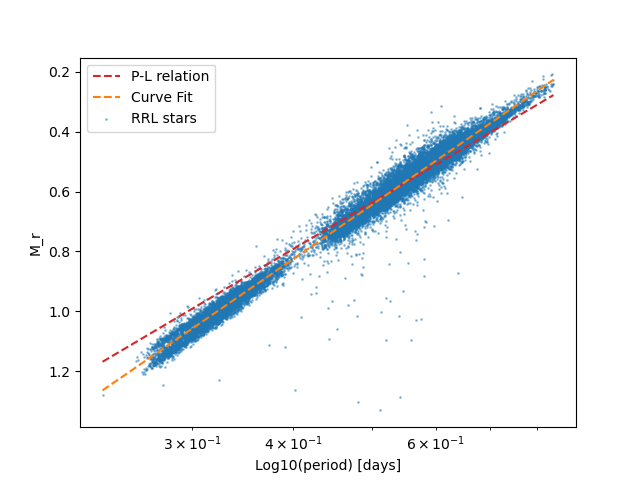

In [62]:
# Get rid of all data with Nan for mean_r 
tbl = tbl.dropna(subset = ['mean_r'])
wgood = tbl['prob_rrl'] > 0.95
# Combine nan mask and wgood mask


#Distance modulus:  m - 5 log(d) + 5 - A = M 
tbl['Mr'] = tbl['mean_r'] - 5*np.log10(tbl['distance']) + 5 - 2.27*tbl['ebv']

# Scatter plot the data
fig = plt.figure()

plt.scatter(tbl[wgood]['best_period'], 
            tbl[wgood]['Mr'], 
            s = 1, 
            alpha = 0.4, 
            label = 'RRL stars',
            c = 'tab:blue')

# Plot the linear relation
time = np.linspace(min(tbl[wgood]['best_period']),
                   max(tbl[wgood]['best_period']),
                   100)
y_fit = -1.6 * np.log10(time/0.6)+ 0.51
plt.plot(time, y_fit, color = 'tab:red', ls = '--', label = 'P-L relation')

# Find a model that fits better
def model_PL(time, a, c):
    # Return a linear relation like that above: 
    return a * np.log10(time/0.6)+c

p, _ = curve_fit(model_PL, tbl[wgood]['best_period'], tbl[wgood]['Mr'])

# Plot the results of the curve fit
y_optimum_fit = model_PL(time, *p)
plt.plot(time, y_optimum_fit, color = 'tab:orange', ls = '--', label = 'Curve Fit')


plt.gca().invert_yaxis()
plt.semilogx()
plt.xlabel('Log10(period) [days]')
plt.ylabel('M_r')
plt.legend()

In [63]:
p

array([-1.86353931,  0.49709249])

## 3. Estimate distance from the Period-Luminosity relation.

Now let's compute the distance our period-luminosity relationship implies for the RR Lyrae in exercise 1.

We will need the E(B-V) value at the source location, which we are providing you:

**E(B-V) = 0.012 mag**

In [70]:
ztf_src_ebv = 0.012

But you *could* programatically get it like this:

In [71]:
# from astroquery.ipac.irsa.irsa_dust import IrsaDust
# from astropy.coordinates import SkyCoord

# ztf_src_sc = SkyCoord(mean_ra, mean_dec, unit='degree')

# ztf_src_ebv = IrsaDust.get_query_table(ztf_src_sc,section='ebv')['ext SFD mean'].value[0]
# ztf_src_ebv

For this exercise:

* Use the period-luminosity relationship and the best-fit period of the source from Exercise 1 to **estimate the  distance in parsecs to our RR Lyr star.**

In [82]:
# Begin by using the period to calculate the absolute magnitude: 
absol_mag = model_PL(1/best_freq.value, *p)

# Next use the distance modulus to calculate the distance to the star using the mean_r magnitude:
#    d= 10**((M - m - 5 + A)/-5)
mean_r = np.mean(ts[wr]['mag'])
d = 10**((absol_mag - mean_r - 5 + 2.27*ztf_src_ebv)/-5)
print(f'The distance is given by {d:0.1f} parcecs')

The distance is given by 18391.5 parcecs
